In [1]:
import chex
import jax.numpy as jnp
from jax.scipy.signal import correlate2d
import jax
from enum import Enum
from typing import List
from jax import lax
from dataclasses import field, dataclass

In [2]:
GOMOKU_BOARD_SIZE = 20

class Player(Enum):
    PLAYER_1 = 1
    PLAYER_2 = 2
    # A methord to get the other
    @classmethod
    def other(cls, player: int):
        return lax.cond(player == cls.PLAYER_1.value, lambda _: cls.PLAYER_2.value, lambda _: cls.PLAYER_1.value, None)
        
@chex.dataclass(frozen=True)
class Board:
    """
    This holds the current state of the board which is a 2D array of size GOMOKU_BOARD_SIZE x GOMOKU_BOARD_SIZE.
    Moves of the players are represented by 1 and 2 respectively.
    """
    # 0 for empty, 1 for player 1, 2 for player 2.
    state: chex.ArrayDevice = field(default_factory=lambda:jnp.zeros(
        (GOMOKU_BOARD_SIZE, GOMOKU_BOARD_SIZE), dtype=jnp.int32))
    # Choosing not to retain enums as they are not stackable with jax.
    player: int = Player.PLAYER_1.value  # The player who is making the next move.
    # An equals method for testing.

    @classmethod
    def make(cls, state: chex.ArrayDevice, player: Player) -> 'Board':
        """
        A helper function to create a board object.
        """
        return cls(state=state, player=player.value)
    
    @classmethod
    def make_canonical(cls, state: chex.ArrayDevice) -> 'Board':
        """
        A helper function to create a board object.
        """
        return cls(state=state, player=Player.PLAYER_1.value)

    def __eq__(self, other):
        return jnp.all(self.state == other.state) and self.player == other.player
    
    def canonical(self):
        """
        This function returns a board such that it's always the player 1's turn. 
        Useful when running self-play style search algorithms
        """
        def flip():
            # flip the player values
            player_1_spots = self.state == Player.PLAYER_1.value
            player_2_spots = self.state == Player.PLAYER_2.value
            state = jnp.zeros((GOMOKU_BOARD_SIZE, GOMOKU_BOARD_SIZE), dtype=self.state.dtype)
            state = jnp.where(player_1_spots, Player.PLAYER_2.value, state)
            state = jnp.where(player_2_spots, Player.PLAYER_1.value, state)
            return Board.make(state=state, player=Player.PLAYER_1)
        return lax.cond(self.player == Player.PLAYER_1.value,
            lambda: self,
            lambda: flip())
            


@chex.dataclass(frozen=True)
class GameOutcome:
    """
    This holds the outcome of a game.
    """
    class WinType(Enum):
        ROW = 0
        COL = 1
        DIAG = 2
        ALT_DIAG = 3
        DRAW = 4
    winner: int = -1  # The winner of the game.
    row_loc: int = -1  # Row location of the winning move.
    col_loc: int = -1  # Column location of the winning move.
    win_type: int = -1  # Type of the winning move.


@chex.dataclass(frozen=True)
class StepOutput:
    """
    This holds the output of the step function.
    """
    board: Board
    reward: int
    done: bool
    # An equals method for testing.

    def __eq__(self, other):
        return self.board == other.board and self.reward == other.reward and self.done == other.done


class GomokuEnv:
    @classmethod
    def action_to_index(cls, action: int) -> (int, int):
        """
        This function takes an action and returns the corresponding 2D index.
        param action: An integer between 0 and 399.
        """
        row = action // GOMOKU_BOARD_SIZE
        col = action % GOMOKU_BOARD_SIZE
        return (row, col)

    @classmethod
    def kernels(cls, kernel_size=5) -> jnp.ndarray:
        """
        This function returns the kernels for checking if there is a winner.
        """
        row_kernel = jnp.zeros((kernel_size, kernel_size))
        # set the first row to 1.
        row_kernel = row_kernel.at[0, :].set(1)
        col_kernel = row_kernel.T
        diag_kernel = jnp.eye(kernel_size)
        alt_diag_kernel = jnp.fliplr(diag_kernel)
        # All kernels stacked together.
        kernels = jnp.stack(
            [row_kernel, col_kernel, diag_kernel, alt_diag_kernel])
        return kernels

    @classmethod
    def __expanded_board(cls, board: Board) -> jnp.ndarray:
        """
        This function takes a board and returns an expanded version of it.
        The expanded board has one channel for each player.
        param board: A board object whose state needs to be expanded.
        """
        return jnp.stack([board.state == Player.PLAYER_1.value,
                          board.state == Player.PLAYER_2.value]).astype(jnp.int32)

    @classmethod
    def __win_locations(cls, board: Board) -> jnp.ndarray:
        """
        This function takes a board and finds the locations of the winning move.
        param board: A board object whose state needs to be expanded.
        returns: A 2D array of size Nx3 where N is the number of winning moves as computed by the location where the kernels were operated on.
        The three columns are the (kernel index per player, row index and column index). 
        0-3 kernel index corresponds to player 1 and 4-8 kernel index corresponds to player 2.
        It returns an array of size (GOMOKU_BOARD_SIZE*GOMOKU_BOARD_SIZE, 3)
        """
        kernels = cls.kernels()
        board_expanded = cls.__expanded_board(board)
        # valid mode of convolution is a mode that does not extend the board.
        kernel_outputs = jnp.array([correlate2d(board_of_player, kernel, mode="valid")
                                   for board_of_player in board_expanded for kernel in kernels])
        # Check if there is a winner using argwhere for the value is equal to the number of pieces in a row.
        locations = jnp.argwhere(kernel_outputs == kernels.shape[1], size=GOMOKU_BOARD_SIZE*GOMOKU_BOARD_SIZE, fill_value=-1)
        return locations

    @classmethod
    def assert_valid(cls, board: Board) -> bool:
        """
        A helper function to check if a board is valid. This checks the following:
        1. The board is a 2D array of size 20x20.
        2. The board has only 0, Player.PLAYER_1.value and Player.PLAYER_2.value
        3. It does not have multiple winners.
        4. Each player played the same number of moves or one more move.
        Raise a unique error if any of the above conditions are not satisfied.
        """
        # Check the shape of the board.
        if board.state.shape != (GOMOKU_BOARD_SIZE, GOMOKU_BOARD_SIZE):
            raise ValueError(
                f"The board state is not of shape ({GOMOKU_BOARD_SIZE}, {GOMOKU_BOARD_SIZE}).")
        # Check that the board has only 0, 1 and 2.
        if not jnp.all(jnp.isin(board.state, jnp.array([0, Player.PLAYER_1.value, Player.PLAYER_2.value], dtype=jnp.int32))):
            raise ValueError(
                f"The board state has values other than 0, {Player.PLAYER_1.value} and {Player.PLAYER_2.value}.")
        # Check that the board does not have multiple winners.
        if jnp.count_nonzero(cls.__win_locations(board)[:,0] != -1) > 1:
            raise ValueError("The board has multiple winners.")
        # Check that the number of moves played by each player is the same or one more.
        if jnp.sum(board.state == Player.PLAYER_1.value) - jnp.sum(board.state == Player.PLAYER_2.value) not in [0, 1]:
            raise ValueError(
                f"The number of moves played by each player is not the same or one more."
                f"Player 1: {jnp.sum(board.state == Player.PLAYER_1.value)},"
                f"Player 2: {jnp.sum(board.state == Player.PLAYER_2.value)}")
        return True
    
    @classmethod
    def outcome(cls, board: Board) -> GameOutcome:
        """
        Determine the outcome of the game given the current board state.
        """

        def has_winner(locations):
            win_type_code = locations[0, 0]
            player = jax.lax.cond(win_type_code < 4, lambda _: Player.PLAYER_1.value, lambda _: Player.PLAYER_2.value, None)
            win_type = win_type_code % 4 # 0-3 for player 1 and 4-7 for player 2
            row_loc = locations[0, 1]
            col_loc = locations[0, 2] + jax.lax.cond(win_type == GameOutcome.WinType.ALT_DIAG.value, lambda _: 4, lambda _: 0, None)
            return GameOutcome(winner=player, row_loc=row_loc, col_loc=col_loc, win_type=win_type)

        def no_winner(_):
            # If the board is full, it's a draw.
            draw = jnp.all(board.state != 0)
            return GameOutcome(
                winner=-1,
                row_loc=-1,
                col_loc=-1,
                win_type=jax.lax.cond(draw, lambda _: GameOutcome.WinType.DRAW.value, lambda _: -1, None)
            )

        locations = cls.__win_locations(board)

        # Use lax.cond to determine if there is a winner or not.
        # If there is a winner, then at least one of the locations will be non -1.
        return lax.cond(
            (locations.all() != -1) & (jnp.count_nonzero(locations[:, 0] != -1) == 1),
            lambda locations: has_winner(locations),
            lambda locations: no_winner(locations),
            locations
        )
    
    @classmethod
    def step(cls, board: Board, action: int, player: int) -> StepOutput:
        """
        This function takes a board state and an action and returns the new board state.
        This function also checks if the game is over, and returns the reward.
        param board: A valid board object.
        param action: An integer between 0 and 399.
        param player: The player who is making the move.
        """
        def game_over(_):
            return StepOutput(board=board, reward=-1, done=True)

        def valid_action(_):
            row, col = cls.action_to_index(action)
            return lax.cond(
                (board.state[row, col] != 0) | (player != board.player),
                game_over,
                update_state,
                None
            )

        def update_state(_):
            row, col = cls.action_to_index(action)
            new_state = Board(state=board.state.at[row, col].set(player), player=Player.other(player))
            outcome = cls.outcome(new_state)
            reward = lax.cond(
                outcome.winner == player,
                lambda _: 1,
                lambda _: lax.cond(
                    outcome.winner == Player.other(player),
                    lambda _: -1,
                    lambda _: 0,
                    None
                ),
                None
            )
            return StepOutput(board=new_state, reward=reward, done=outcome.win_type != -1)

        # Check if the action is out of range or the game is already over.
        return lax.cond(
            (action < 0) | (action >= GOMOKU_BOARD_SIZE * GOMOKU_BOARD_SIZE) | (cls.outcome(board).win_type != -1),
            game_over,
            valid_action,
            None
        )


In [3]:
# A class to produce gomoku scenarios easily for unit testing.

@chex.dataclass(frozen=True)
class GomokuStroke:
    class StrokeType(Enum):
        ROW = 0
        COL = 1
        DIAG = 2
        ALT_DIAG = 3
    """Describes a stroke to paint on the board."""
    player: int
    row: int
    col: int
    stroke_type: StrokeType
    length: int

class GomokuScenario:
    """
    This class is used to produce scenarios for unit testing. Give it a list of strokes and it will produce a board.
    """
    @classmethod
    def make_scenario(cls, strokes: List[GomokuStroke], end_player: Player):
        """
        This function takes a list of strokes and produces a board.
        The player field in the returned board is set to the end_player.
        """
        state = jnp.zeros((GOMOKU_BOARD_SIZE, GOMOKU_BOARD_SIZE), dtype=jnp.int32)
        for stroke in strokes:
            kernels = GomokuEnv.kernels(kernel_size=stroke.length)
            kernel = kernels[stroke.stroke_type.value]
            starting_column = stroke.col if stroke.stroke_type != GomokuStroke.StrokeType.ALT_DIAG else stroke.col - stroke.length + 1
            state = state.at[stroke.row:stroke.row+stroke.length, starting_column: starting_column+stroke.length].set(
                jnp.where(kernel == 1, stroke.player.value, state[stroke.row:stroke.row+stroke.length, starting_column: starting_column+stroke.length])
                )
        return Board.make(state=state, player=end_player)

# Unit Tests

In [4]:
import unittest
import numpy as np

In [5]:
# Example usage and unit test
class TestGomokuScenarioMaker(unittest.TestCase):
    def test_scenario_with_all_stroke_types(self):
        strokes = [
            GomokuStroke(player=Player.PLAYER_1, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=5),
            GomokuStroke(player=Player.PLAYER_2, row=1, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=2),
            GomokuStroke(player=Player.PLAYER_1, row=3, col=0, stroke_type=GomokuStroke.StrokeType.DIAG, length=3),
            GomokuStroke(player=Player.PLAYER_2, row=4, col=4, stroke_type=GomokuStroke.StrokeType.ALT_DIAG, length=5),
        ]
        scenario = GomokuScenario.make_scenario(strokes, Player.PLAYER_1)
        expected_array = jnp.array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
        
        np.testing.assert_array_equal(scenario.state, expected_array)
        self.assertEqual(scenario.player, Player.PLAYER_1.value)
    
    def test_scenario_with_one_alt_diag(self):
        scenario = GomokuScenario.make_scenario([
            GomokuStroke(player=Player.PLAYER_1, row=0, col=6, stroke_type=GomokuStroke.StrokeType.ALT_DIAG, length=5),
            GomokuStroke(player=Player.PLAYER_2, row=6, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=4),
        ], Player.PLAYER_1)

        expected_first_12_by_12 = jnp.array([
            [0,0,0,0,0,0,1,0,0,0,0,0],
            [0,0,0,0,0,1,0,0,0,0,0,0],
            [0,0,0,0,1,0,0,0,0,0,0,0],
            [0,0,0,1,0,0,0,0,0,0,0,0],
            [0,0,1,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0],
            [2,0,0,0,0,0,0,0,0,0,0,0],
            [2,0,0,0,0,0,0,0,0,0,0,0],
            [2,0,0,0,0,0,0,0,0,0,0,0],
            [2,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0,0,0,0]])
        
        np.testing.assert_array_equal(scenario.state[:12, :12], expected_first_12_by_12)

unittest.main(argv=['-k', 'TestGomokuScenarioMaker'], verbosity=2, exit=False)


test_scenario_with_all_stroke_types (__main__.TestGomokuScenarioMaker.test_scenario_with_all_stroke_types) ... ok
test_scenario_with_one_alt_diag (__main__.TestGomokuScenarioMaker.test_scenario_with_one_alt_diag) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.800s

OK


In [6]:
class TestGomokuEnv(unittest.TestCase):
    # Test the __action_to_index function.
    def test_action_to_index(self):
        self.assertEqual(GomokuEnv.action_to_index(0), (0, 0))
        self.assertEqual(GomokuEnv.action_to_index(399), (19, 19))
        self.assertEqual(GomokuEnv.action_to_index(200), (10, 0))
        self.assertEqual(GomokuEnv.action_to_index(399), (19, 19))
    
    # Test that the kernels are correct.
    def test_kernels(self):
        kernels = GomokuEnv.kernels()
        self.assertEqual(kernels.shape, (4, 5, 5))
        self.assertTrue(jnp.all(kernels[0] == jnp.array([[1, 1, 1, 1, 1],
                                                         [0, 0, 0, 0, 0],
                                                         [0, 0, 0, 0, 0],
                                                         [0, 0, 0, 0, 0],
                                                         [0, 0, 0, 0, 0]])))
        self.assertTrue(jnp.all(kernels[1] == jnp.array([[1, 0, 0, 0, 0],
                                                         [1, 0, 0, 0, 0],
                                                         [1, 0, 0, 0, 0],
                                                         [1, 0, 0, 0, 0],
                                                         [1, 0, 0, 0, 0]])))
        self.assertTrue(jnp.all(kernels[2] == jnp.array([[1, 0, 0, 0, 0],
                                                            [0, 1, 0, 0, 0],
                                                            [0, 0, 1, 0, 0],
                                                            [0, 0, 0, 1, 0],
                                                            [0, 0, 0, 0, 1]])))
        self.assertTrue(jnp.all(kernels[3] == jnp.array([[0, 0, 0, 0, 1],
                                                            [0, 0, 0, 1, 0],
                                                            [0, 0, 1, 0, 0],
                                                            [0, 1, 0, 0, 0],
                                                            [1, 0, 0, 0, 0]])))
    
    # Create a few boards that are invalid and check that assert_valid raises an error.
    def test_assert_invalid(self):
        # Test that the board is of the right shape.
        with self.assertRaises(ValueError):
            GomokuEnv.assert_valid(Board(state=jnp.zeros((10, 10), dtype=jnp.int32)))
        # Test that the board has only 0, 1 and 2.
        with self.assertRaises(ValueError):
            GomokuEnv.assert_valid(Board(state=312*jnp.ones((20, 20), dtype=jnp.int32)))
        # Test that the board has only one winner.
        with self.assertRaises(ValueError):
            GomokuEnv.assert_valid(GomokuScenario.make_scenario([
                GomokuStroke(player=Player.PLAYER_1, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=5),
                GomokuStroke(player=Player.PLAYER_2, row=1, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=5),
            ], Player.PLAYER_1))  # This has two winners.
        # Test that the number of moves played by each player is the same or one more.
        with self.assertRaises(ValueError):
            GomokuEnv.assert_valid(GomokuScenario.make_scenario([
                GomokuStroke(player=Player.PLAYER_1, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=4),
                GomokuStroke(player=Player.PLAYER_2, row=1, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=3),
                GomokuStroke(player=Player.PLAYER_1, row=2, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=2),
            ], Player.PLAYER_1))
    
    # Create a few boards that are valid and check that assert_valid does not raise an error.
    def test_assert_valid(self):
        GomokuEnv.assert_valid(GomokuScenario.make_scenario([
            GomokuStroke(player=Player.PLAYER_1, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=5),
            GomokuStroke(player=Player.PLAYER_2, row=1, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=4),
        ], Player.PLAYER_1))
        GomokuEnv.assert_valid(GomokuScenario.make_scenario([
            GomokuStroke(player=Player.PLAYER_1, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=4),
            GomokuStroke(player=Player.PLAYER_2, row=1, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=4),
            GomokuStroke(player=Player.PLAYER_1, row=6, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=1),
        ], Player.PLAYER_1))

    # Test that we can asses a winning outcome and correctly locate it in an alternate diagonal scenario
    def test_winning_outcome_alt_diag(self):
        outcome = GomokuEnv.outcome(GomokuScenario.make_scenario([
            GomokuStroke(player=Player.PLAYER_1, row=0, col=6, stroke_type=GomokuStroke.StrokeType.ALT_DIAG, length=5),
            GomokuStroke(player=Player.PLAYER_2, row=6, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=4),
        ], Player.PLAYER_1))
        self.assertEqual(outcome.winner, Player.PLAYER_1.value)
        self.assertEqual(outcome.win_type, GameOutcome.WinType.ALT_DIAG.value)
        self.assertEqual(outcome.row_loc, 0)
        self.assertEqual(outcome.col_loc, 6)
    
    # Test that we can asses a winning outcome and correctly locate it in a row scenario
    def test_winning_outcome_row(self):
        outcome = GomokuEnv.outcome(GomokuScenario.make_scenario([
            GomokuStroke(player=Player.PLAYER_1, row=10, col=10, stroke_type=GomokuStroke.StrokeType.ROW, length=5),
            GomokuStroke(player=Player.PLAYER_2, row=6, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=4),
        ], Player.PLAYER_1))
        self.assertEqual(outcome.winner, Player.PLAYER_1.value)
        self.assertEqual(outcome.win_type, GameOutcome.WinType.ROW.value)
        self.assertEqual(outcome.row_loc, 10)
        self.assertEqual(outcome.col_loc, 10)
    
    # Test that we can assess a ongoing game state
    def test_ongoing_outcome(self):
        # Create a random but valid game state
        outcome = GomokuEnv.outcome(GomokuScenario.make_scenario([
            GomokuStroke(player=Player.PLAYER_1, row=10, col=10, stroke_type=GomokuStroke.StrokeType.ROW, length=3),
            GomokuStroke(player=Player.PLAYER_2, row=6, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=4),
        ], Player.PLAYER_1))
        self.assertEqual(outcome.winner, -1)
        self.assertEqual(outcome.win_type, -1)
        self.assertEqual(outcome.row_loc, -1)
        self.assertEqual(outcome.col_loc, -1)

    # Test that the step function works as expected in multiple scenarios
    def test_multiple_steps(self):
        # Create an empty board
        board = Board()
        output = GomokuEnv.step(board, 0, Player.PLAYER_1.value)
        expected_output = StepOutput(board=GomokuScenario.make_scenario([
            GomokuStroke(player=Player.PLAYER_1, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=1),
        ], Player.PLAYER_2), reward=0, done=False)
        self.assertEqual(output, expected_output)
        # Now try adding another move at the same location and see that the state is done and reward is -1
        abrupt_end_output = GomokuEnv.step(output.board, 0, Player.PLAYER_2.value)
        self.assertEqual(abrupt_end_output.reward, -1)
        self.assertEqual(abrupt_end_output.done, True)
        # Now let's play the game a few more steps
        output = GomokuEnv.step(output.board, 100, Player.PLAYER_2.value)
        output = GomokuEnv.step(output.board, 1, Player.PLAYER_1.value)
        output = GomokuEnv.step(output.board, 101, Player.PLAYER_2.value)
        output = GomokuEnv.step(output.board, 2, Player.PLAYER_1.value)
        output = GomokuEnv.step(output.board, 102, Player.PLAYER_2.value)
        output = GomokuEnv.step(output.board, 3, Player.PLAYER_1.value)
        output = GomokuEnv.step(output.board, 103, Player.PLAYER_2.value)
        output = GomokuEnv.step(output.board, 4, Player.PLAYER_1.value)
        expected_final_output = StepOutput(board=GomokuScenario.make_scenario([
            GomokuStroke(player=Player.PLAYER_1, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=5),
            GomokuStroke(player=Player.PLAYER_2, row=5, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=4),
        ], Player.PLAYER_2), reward=1, done=True)
        self.assertEqual(output, expected_final_output)
    
    # Test that the canonical function flips the board correctly
    def test_canonical(self):
        canonical_board = GomokuScenario.make_scenario([
            GomokuStroke(player=Player.PLAYER_1, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=5),
            GomokuStroke(player=Player.PLAYER_2, row=1, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=4),
        ], Player.PLAYER_1)
        board = GomokuScenario.make_scenario([
            GomokuStroke(player=Player.PLAYER_2, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=5),
            GomokuStroke(player=Player.PLAYER_1, row=1, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=4),
        ], Player.PLAYER_2)
        self.assertEqual(board.canonical(), canonical_board)

        # When we have a player 1 perspective canonical board is the same is the original board.
        self.assertEqual(canonical_board.canonical(), canonical_board)

unittest.main(argv=['-k', 'TestGomokuEnv'], verbosity=2, exit=False)
                                                                


test_action_to_index (__main__.TestGomokuEnv.test_action_to_index) ... ok
test_assert_invalid (__main__.TestGomokuEnv.test_assert_invalid) ... ok
test_assert_valid (__main__.TestGomokuEnv.test_assert_valid) ... ok
test_canonical (__main__.TestGomokuEnv.test_canonical) ... ok
test_kernels (__main__.TestGomokuEnv.test_kernels) ... ok
test_multiple_steps (__main__.TestGomokuEnv.test_multiple_steps) ... ok
test_ongoing_outcome (__main__.TestGomokuEnv.test_ongoing_outcome) ... ok
test_winning_outcome_alt_diag (__main__.TestGomokuEnv.test_winning_outcome_alt_diag) ... ok
test_winning_outcome_row (__main__.TestGomokuEnv.test_winning_outcome_row) ... ok

----------------------------------------------------------------------
Ran 9 tests in 5.491s

OK


# Experimenting with MCTS

To use the `mctx` library we need to define the following components:

### The `recurrent_fn(params, rng_key, action, embedding)-> (RecurrentFnOutput, new_embedding)`

* params: A pytree to hold various parameters that might be used in the recurrent function (maybe learned components?)
* rng_key: A psuedo random generator seed which will be used in the MCTS search
* action: A jax array specifying which action to take
* empbedding: A jax array specifying the embedding of the current state

The function should return a tuple of an object of the type `RecurrentFnOutput` and a new embedding. It has the following fields:

* reward: A jax array which represents the reward for taking the action
* discount: A jax array which represents the discount which needs to be applied to the value when added to the reward
* prior_logits: A jax array with the unnormalized probabilities of the action space given the new state we are in after taking the action
* value: A jax array with the value of this particular root state


### The `RootFnOutput`

This is the representation of the root state from which the mcts will be run. Usually the fields of this struct would be filled with
what is computed from a representation neural network. The fields are:

* prior_logits: A jax array with the un-normalized probability values of taking any action of all possible actions in the action space
* value: A jax array with the estimated value of this particular root state
* embedding: A jax array specifying the embedding of the current state 

### The call to mcts to get an informed action
```
policy_output = mctx.gumbel_muzero_policy(params, rng_key, root, recurrent_fn,
                                          num_simulations=32)
```

## A naive implementation
Let's create a simple MCTS agent which does not have any prior information or learned components so:
* All the prior logits are equally distributed since we don't know anything about the prior: `naive_prior(state: chex.Array)`
    - The naive_prior would be as simple as taking all the empty-cells and giving them equal values of (1) and non-empty cells with (0)
* For the estimated value we can implement a constant value function which will return a constant value of 0.5 `constant_value() -> 0.5`
* The embedding will just be a jax array of the 2D board
* The recurrent function should return a **canonical observation**. i.e. The board should always look like it's the first player's turn. This is important because `Gomoku`
is a game where the "environment dynamics" is the other player. Since we don't have anothe player, we play against ourself and hope that this gives enough information about
the underlying game dynamics and that any rational player with an intent to win would also play the same way.

In [7]:
import mctx

In [8]:
class NaiveMcts:
    @classmethod
    def prior(cls, board: chex.Array):
        """
        This function returns a uniform prior over all legal moves.
        """
        return jnp.where(board == 0, 100, 0).astype(jnp.float32).flatten()

    @classmethod
    def value(cls, done: bool):
        """A naive constant value function for all states"""
        return lax.cond(done, lambda _: 0, lambda _: 1, None)

    @classmethod
    def step(
        cls,
        params: chex.ArrayTree,
        rng_key: int,
        action: chex.Array,
        embedding
    ) -> (mctx.RecurrentFnOutput, chex.Array):
        """A naive step call which calls the gomoku step call and returns a canonical observation and a recurrent fn output"""
        del params, rng_key  # currently unused
        board = embedding
        # step the board
        step_output = GomokuEnv.step(board, action, board.player)
        # Convert the board to a canonical observation
        return (
            mctx.RecurrentFnOutput(
                reward=step_output.reward,
                discount=-1* jnp.ones_like(step_output.reward),
                prior_logits=cls.prior(step_output.board.state),
                value=cls.value(step_output.done),
            ),
            step_output.board
        )

# Roadblock
At this point I realize that all of the above code is not written with vmap or jit in mind. The code functions like step need to be vmappable and dataclasses like Board, StepOutcome, Stroke need to be mappable for this to happen. So let's make sure `GomokuEnv` is completely "vmap"pable and "jit"able.

A quote I found online that is interesting and warrants a redesign of the Board, and how GomokuEnv works:
> vmap supports pytrees when written in the form of a "struct of arrays" rather than an "array of structs". This is because JAX/XLA only has support for numeric array dtypes, so the "array of struct" form can't be operated on efficiently in JAX.

The approach I took:
* First remove any use of optionals and enums in all dataclasses. They are not stackable and castable to jax arrays. At least not that I know of


In [9]:
from jax.tree_util import tree_flatten, tree_unflatten
from jax import tree_map

def pytrees_stack(pytrees, axis=0):
    results = tree_map(
        lambda *values: jnp.stack(values, axis=axis), *pytrees)
    return results

def show_example(structured):
  flat, tree = tree_flatten(structured)
  unflattened = tree_unflatten(tree, flat)
  print(f"{structured=}\n  {flat=}\n  {tree=}\n  {unflattened=}")

class TestVmappedGomokuEnv(unittest.TestCase):
   # Test that the vmapped step function works as expected in multiple scenarios
   def test_multiple_boards(self):
      # Use the vmapped step function to step multiple boards (straght, diag and alt diag, empty)
      # In the first board player 1 wins, in the second board player 2 wins and in the third board the game is ongoing
      board1 = GomokuScenario.make_scenario([
         GomokuStroke(player=Player.PLAYER_1, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=4),
         GomokuStroke(player=Player.PLAYER_2, row=1, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=4),
      ], Player.PLAYER_1)
      expected_board1 = GomokuScenario.make_scenario([
          GomokuStroke(player=Player.PLAYER_1, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=4),
          GomokuStroke(player=Player.PLAYER_2, row=1, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=4),
          GomokuStroke(player=Player.PLAYER_1, row=0, col=4, stroke_type=GomokuStroke.StrokeType.COL, length=1),
        ], Player.PLAYER_2)
      board2 = GomokuScenario.make_scenario([
         GomokuStroke(player=Player.PLAYER_1, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=3),
         GomokuStroke(player=Player.PLAYER_1, row=8, col=8, stroke_type=GomokuStroke.StrokeType.ROW, length=2),
         GomokuStroke(player=Player.PLAYER_2, row=1, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=4),
      ], Player.PLAYER_2)
      expected_board2 = GomokuScenario.make_scenario([
         GomokuStroke(player=Player.PLAYER_1, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=3),
         GomokuStroke(player=Player.PLAYER_1, row=8, col=8, stroke_type=GomokuStroke.StrokeType.ROW, length=2),
         GomokuStroke(player=Player.PLAYER_2, row=1, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=5),
      ], Player.PLAYER_1)
      board3 = GomokuScenario.make_scenario([], Player.PLAYER_1)
      expected_board3 = GomokuScenario.make_scenario([
          GomokuStroke(player=Player.PLAYER_1, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=1),
        ], Player.PLAYER_2)
      boards = pytrees_stack([board1, board2, board3])
      actions = jnp.array([4,100,0])
      players = jnp.array([Player.PLAYER_1.value, Player.PLAYER_2.value, Player.PLAYER_1.value])
      vmapped_step = jax.vmap(GomokuEnv.step, in_axes=(0, 0, 0))
      output = vmapped_step(boards,actions,players)
      # Check that the output is correct
      expected_output = pytrees_stack([
         StepOutput(board=expected_board1, reward=1, done=True),
         StepOutput(board=expected_board2, reward=-1, done=True),
         StepOutput(board=expected_board3, reward=0, done=False),
      ])
      np.testing.assert_array_equal(output.board.state, expected_output.board.state)

unittest.main(argv=['-k', 'TestVmappedGomokuEnv'], verbosity=2, exit=False)

test_multiple_boards (__main__.TestVmappedGomokuEnv.test_multiple_boards) ... ok

----------------------------------------------------------------------
Ran 1 test in 1.319s

OK


# Outcome of fixing Roadblock
I had to go back and redo a lot of the `GomokuEnv` class. The following lessons learnt:
* Don't use `if`, `else` conditionals in jax if you want to compile them in. Use `cond`, `select`, `switch` etc
* Don't use enums in your dataclasses. Jax cannot stack them
* Don't use asserts in your jax code. They will not be amenable to jax transformations

JAX conditionals require predicates that have the same type signatures for both true and false conditions. During tracing JAX *WILL* evaluate both predicates just to check if everything will work as needed and to understand the code path in both directions for compiling. So if you have conditionals which change behavior based on input shape etc that is code-smell. Don't do that.

I faced this issue with the win_locations function whose output is of varied size which then get's consumed by a vmappable step function in some conditional. This could not be compiled. Thanfully, `argwhere` has a mode where it will always return a fixed size output. So using that helped solve that issue. I hope the gradient landscape is not screwed up by this lol. I don't think it would be.

In [10]:
import unittest

class TestNaiveMctsHelpers(unittest.TestCase):
    @staticmethod
    def recurrent_fn_output_equals(output: mctx.RecurrentFnOutput, expected_output: mctx.RecurrentFnOutput):
        return np.allclose(output.value, expected_output.value) and \
            np.allclose(output.prior_logits, expected_output.prior_logits) and \
                np.allclose(output.discount, expected_output.discount) and \
                    np.allclose(output.reward, expected_output.reward)
    
    # Test that when given a board it returns a prior which is effectively the flatten on that board
    def test_naive_prior(self):
        custom_board = GomokuScenario.make_scenario([
            GomokuStroke(player=Player.PLAYER_1, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=5),
            GomokuStroke(player=Player.PLAYER_2, row=1, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=4),
        ], Player.PLAYER_1)
        prior = NaiveMcts.prior(custom_board.state)
        expected_prior = jnp.where(custom_board.state == 0, 100., 0.).flatten()
        np.testing.assert_array_equal(prior, expected_prior)
    
    # Test that step call through the recurrent function approach
    def test_naive_step(self):
        # Create a random scenario first
        custom_board = GomokuScenario.make_scenario([
            GomokuStroke(player=Player.PLAYER_1, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=4),
            GomokuStroke(player=Player.PLAYER_2, row=1, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=4),
        ], Player.PLAYER_1).canonical()
        # Now call the naive step function
        output, board = NaiveMcts.step((), 4, 4, custom_board)
        expected_board = GomokuEnv.step(custom_board, 4, Player.PLAYER_1.value).board
        expected_logits = jnp.where(expected_board.state == 0, 100., 0.).flatten()
        expected_output = mctx.RecurrentFnOutput(value=0, prior_logits=expected_logits, discount=-1, reward=1.) # action 4 is a winning move in this scenario
        self.assertTrue(self.recurrent_fn_output_equals(output, expected_output))
        self.assertTrue(np.allclose(expected_board.state, board.state))
    
    def test_naive_step_vmaped(self):
        # Create a random scenario
        custom_board = GomokuScenario.make_scenario([
            GomokuStroke(player=Player.PLAYER_1, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=4),
            GomokuStroke(player=Player.PLAYER_2, row=1, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=4),
        ], Player.PLAYER_1).canonical()
        # Stack the two boards such that the batched dimension is the first dimension
        stacked_board_states = jnp.stack([custom_board.state, custom_board.state])
        boards = Board(state=stacked_board_states, player=jnp.array([Player.PLAYER_1.value, Player.PLAYER_1.value]))
        stacked_actions = jnp.array([4, 7])
        self.assertTrue(stacked_board_states.shape == (2, GOMOKU_BOARD_SIZE, GOMOKU_BOARD_SIZE))
        # Transform the naive step function to a vmaped version
        vmapped_step = jax.vmap(NaiveMcts.step, in_axes=(None, None, 0, 0))
        # Call the vmapped step function
        output, board = vmapped_step((), 4, stacked_actions, boards)
        expected_board1 = GomokuEnv.step(custom_board, 4, Player.PLAYER_1.value).board
        expected_board2 = GomokuEnv.step(custom_board, 7, Player.PLAYER_1.value).board
        expected_rewards = jnp.array([1., 0.])
        expected_logits1 = jnp.where(expected_board1.state == 0, 100., 0.)
        expected_logits2 = jnp.where(expected_board2.state == 0, 100., 0.)
        expected_output = mctx.RecurrentFnOutput(value=jnp.array([0,1]), prior_logits=jnp.stack([expected_logits1.flatten(), expected_logits2.flatten()]), discount=jnp.array([-1,-1]), reward=expected_rewards)
        self.assertTrue(self.recurrent_fn_output_equals(output, expected_output))
        self.assertTrue(np.allclose(expected_board1.state, board.state[0]))
        self.assertTrue(np.allclose(expected_board2.state, board.state[1]))
        

# just run the tests in the class TestNaiveMctsHelpers
unittest.main(argv=['-k', 'TestNaiveMctsHelpers'], verbosity=2, exit=False)

test_naive_prior (__main__.TestNaiveMctsHelpers.test_naive_prior) ... ok
test_naive_step (__main__.TestNaiveMctsHelpers.test_naive_step) ... ok
test_naive_step_vmaped (__main__.TestNaiveMctsHelpers.test_naive_step_vmaped) ... ok

----------------------------------------------------------------------
Ran 3 tests in 3.264s

OK


In [11]:
from functools import partial

In [12]:
GOMOKU_BOARD_SIZE = 5
# Create a gomoku scenario with 4 in a row for both players
scenario = GomokuScenario.make_scenario([
    GomokuStroke(player=Player.PLAYER_1, row=0, col=0, stroke_type=GomokuStroke.StrokeType.ROW, length=4),
    GomokuStroke(player=Player.PLAYER_2, row=1, col=0, stroke_type=GomokuStroke.StrokeType.COL, length=4),
], Player.PLAYER_1).canonical()

prior_logits = jnp.where(scenario.state == 0, 1., 0.).flatten().reshape(1,-1)
value = jnp.array([100]).reshape(1,)
embedding = Board(state=scenario.state.reshape(1, GOMOKU_BOARD_SIZE, GOMOKU_BOARD_SIZE), player=jnp.array([Player.PLAYER_1.value]))

root = mctx.RootFnOutput(prior_logits=prior_logits, value=value, embedding=embedding)
recurrent_fn = jax.jit(jax.vmap(NaiveMcts.step, in_axes=(None, None, 0, 0)))
rng_key = jax.random.PRNGKey(4)
rng_key_1, rng_key_2 = jax.random.split(rng_key, 2)
policy_output = mctx.muzero_policy((), rng_key_1, root, recurrent_fn,
                                          num_simulations=3000)

/Users/kartik.arcot/Library/Caches/pypoetry/virtualenvs/gomoku-NgSRe4YC-py3.11/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [13]:
print(f"The recommended action is {policy_output.action}. The winning move is 4!")

The recommended action is [4]. The winning move is 4!


In [14]:
logits = policy_output.search_tree.children_prior_logits
softmax = jax.nn.softmax(logits[0,1,:])
print(f"The softmax of the logits is {softmax}")
print(f"The prior logits are {logits[0,1,:]}")

The softmax of the logits is [0.     0.     0.     0.     0.0625 0.     0.0625 0.0625 0.0625 0.0625
 0.     0.0625 0.0625 0.0625 0.0625 0.     0.0625 0.0625 0.0625 0.
 0.     0.0625 0.0625 0.0625 0.0625]
The prior logits are [  0.   0.   0.   0. 100.   0. 100. 100. 100. 100.   0. 100. 100. 100.
 100.   0. 100. 100. 100.   0.   0. 100. 100. 100. 100.]


> The mctx repo has a very nice function to visualize a mctx simulation. Dropping it in here to help visualize!
This needs a pygraphviz dependency.

Note: I could not easily add pygraphviz through poetry. It's not self contained apparently. So this dependency is not currently reflected in the toml file :(

In [15]:
import pygraphviz
from typing import Optional, Sequence

def convert_tree_to_graph(
    tree: mctx.Tree,
    action_labels: Optional[Sequence[str]] = None,
    batch_index: int = 0
) -> pygraphviz.AGraph:
  """Converts a search tree into a Graphviz graph.

  Args:
    tree: A `Tree` containing a batch of search data.
    action_labels: Optional labels for edges, defaults to the action index.
    batch_index: Index of the batch element to plot.

  Returns:
    A Graphviz graph representation of `tree`.
  """
  chex.assert_rank(tree.node_values, 2)
  batch_size = tree.node_values.shape[0]
  if action_labels is None:
    action_labels = range(tree.num_actions)
  elif len(action_labels) != tree.num_actions:
    raise ValueError(
        f"action_labels {action_labels} has the wrong number of actions "
        f"({len(action_labels)}). "
        f"Expecting {tree.num_actions}.")

  def node_to_str(node_i, reward=0, discount=1):
    return (f"{node_i}\n"
            f"Reward: {reward:.2f}\n"
            f"Discount: {discount:.2f}\n"
            f"Value: {tree.node_values[batch_index, node_i]:.2f}\n"
            f"Visits: {tree.node_visits[batch_index, node_i]}\n")

  def edge_to_str(node_i, a_i):
    node_index = jnp.full([batch_size], node_i)
    probs = jax.nn.softmax(tree.children_prior_logits[batch_index, node_i])
    return (f"{action_labels[a_i]}\n"
            f"Q: {tree.qvalues(node_index)[batch_index, a_i]:.2f}\n"  # pytype: disable=unsupported-operands  # always-use-return-annotations
            f"p: {probs[a_i]:.2f}\n")

  graph = pygraphviz.AGraph(directed=True)

  # Add root
  graph.add_node(0, label=node_to_str(node_i=0), color="green")
  # Add all other nodes and connect them up.
  for node_i in range(tree.num_simulations):
    for a_i in range(tree.num_actions):
      # Index of children, or -1 if not expanded
      children_i = tree.children_index[batch_index, node_i, a_i]
      if children_i >= 0:
        graph.add_node(
            children_i,
            label=node_to_str(
                node_i=children_i,
                reward=tree.children_rewards[batch_index, node_i, a_i],
                discount=tree.children_discounts[batch_index, node_i, a_i]),
            color="red")
        graph.add_edge(node_i, children_i, label=edge_to_str(node_i, a_i))

  return graph

Example code to generate pngs with mcts search tree
```python
graph = convert_tree_to_graph(policy_output.search_tree)
output_file = "tree.png"
print(f"Saving tree diagram to: {output_file}")
graph.draw(output_file, prog="dot")
```

Example code to print the mcts search
```python
tree = policy_output.search_tree
for node_i in range(tree.num_simulations):
    print(f"Node {node_i} has {tree.node_visits[0, node_i]} visits and value {tree.node_values[0, node_i]}")
    for a_i in range(tree.num_actions):
        children_i = tree.children_index[0, node_i, a_i]
        if children_i >= 0:
            print(f"Action {a_i} has {tree.children_visits[0, node_i, a_i]} visits and value {tree.children_rewards[0, node_i, a_i]} and goes to node {children_i}")
```

# Moving on to building a neural network piece

Although I don't fully understand the reward and discount engineering here, I want to move on to building the neural network piece. The mcts search seems to continue searching irrespective of a negative reward. This is fair since it does not have a notion of when a game is done etc. However this needs to be somehow represented in the reward/value functions somehow to make the mcts search more efficent.

Following this thread on why choosing a negative discount would help in a two-player self-play setting later on will help clarify further:
* https://stats.stackexchange.com/questions/304386/discount-factor-for-self-play-in-reinforcement-learning
* https://github.com/deepmind/mctx/issues/24#issuecomment-1193281828

In [83]:
from flax import linen as nn
import optax
import plotly.express as px
import pandas as pd

In [67]:
# Implement a simple MLP model to simulate the value function for a given state and prior logits for all actions (same size as the state)
class SimpleMuZeroModel(nn.Module):
    @nn.compact
    def __call__(self, x, prior_logits):
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        value = nn.Dense(features=1)(x)
        policy_logits = nn.Dense(features=GOMOKU_BOARD_SIZE*GOMOKU_BOARD_SIZE)(x)
        return value, policy_logits

# Define a loss function for the model a simple L2 Loss term for the value and a cross entropy loss for the policy
def loss_fn(value, policy_logits, target_value, target_policy_logits):
    value_loss = jnp.mean((value - target_value)**2)
    policy_loss = optax.softmax_cross_entropy(policy_logits, target_policy_logits).mean()
    return value_loss + policy_loss

In [73]:
# Create a toy dataset for training the model and ensuring that it converges as expected. 
# Data should be something trivial like a quadratic loss function and a argmax policy function
# A mapping from a state vector to a value and policy logits.

def toy_dataset(num_samples=10000):
    """A toy dataset for testing."""
    # state vectors of size 400 of values between 0,1
    states = jax.random.uniform(
        key=jax.random.PRNGKey(0), shape=(num_samples, GOMOKU_BOARD_SIZE*GOMOKU_BOARD_SIZE))
    # value is a quadratic function of the state
    value = jnp.sum(states**2, axis=-1, keepdims=True)
    # policy is a argmax function of the state
    policy_output = jnp.argmax(states, axis=-1)
    # policy_logits is a one hot encoding of the policy output
    policy_logits = jax.nn.one_hot(policy_output, GOMOKU_BOARD_SIZE*GOMOKU_BOARD_SIZE)
    # uniform prior logits
    prior_logits = jnp.ones((num_samples, GOMOKU_BOARD_SIZE*GOMOKU_BOARD_SIZE)) / (GOMOKU_BOARD_SIZE*GOMOKU_BOARD_SIZE)
    return states, value, policy_logits, prior_logits

In [76]:
# Create a training step function
@jax.jit
def train_step(params, optimizer_state, states, prior_logits, policy_logits, value):
    """Train one step."""
    # Define a loss function
    def forward(params, states, prior_logits, policy_logits, value):
        value_pred, policy_logits_pred = model.apply(params, states, prior_logits)
        return loss_fn(value_pred, policy_logits_pred, value, policy_logits)
    value_and_grad_loss = jax.value_and_grad(forward)
    loss, grad = value_and_grad_loss(params, states, prior_logits, policy_logits, value)
    # Update the optimizer state
    updates, optimizer_state = optimizer.update(grad, optimizer_state)
    # Update the parameters
    params = optax.apply_updates(params, updates)
    return (loss, params, optimizer_state)

{'params': {'Dense_0': {'bias': (256,), 'kernel': (25, 256)}, 'Dense_1': {'bias': (256,), 'kernel': (256, 256)}, 'Dense_2': {'bias': (1,), 'kernel': (256, 1)}, 'Dense_3': {'bias': (25,), 'kernel': (256, 25)}}}


In [92]:
def toy_train_loop():
    # Create a toy dataset
    states, value, policy_logits, prior_logits = toy_dataset()
    # Create a model and initialize it
    model = SimpleMuZeroModel()
    # Initialize the model with a random input
    params = model.init(jax.random.PRNGKey(0), states[:1], policy_logits[:1])
    # Print the model parameters shapes with tree_map
    print(f"Model parameters shapes:\n {tree_map(lambda x: x.shape, params)}")

    # Create an optimizer
    optimizer = optax.adam(learning_rate=1e-4)
    # Create an optimizer state
    optimizer_state = optimizer.init(params)

    states, value, policy_logits, prior_logits = toy_dataset()

    # Train the model for 1000 steps
    losses = []
    for i in range(1000):
        loss, params, optimizer_state = train_step(params, optimizer_state, states, prior_logits, policy_logits, value)
        if i % 100 == 0:
            print(f"Loss: {loss}")
        losses.append(loss)
    return losses, params

In [93]:
# Plot the losses
losses, params = toy_train_loop()
fig = px.line(x=range(len(losses)), y=losses, title='Losses for toy problem', labels={'x':'Step', 'y':'Loss'})
fig.show()

Model parameters shapes:
 {'params': {'Dense_0': {'bias': (256,), 'kernel': (25, 256)}, 'Dense_1': {'bias': (256,), 'kernel': (256, 256)}, 'Dense_2': {'bias': (1,), 'kernel': (256, 1)}, 'Dense_3': {'bias': (25,), 'kernel': (256, 25)}}}
Loss: 75.56990051269531
Loss: 6.0869669914245605
Loss: 3.684264898300171
Loss: 3.5695204734802246
Loss: 3.4499385356903076
Loss: 3.300150156021118
Loss: 3.1231250762939453
Loss: 2.9212839603424072
Loss: 2.6845343112945557
Loss: 2.4209797382354736


 Nice to see a the model converges on a simple dataset!

# What's next?

Now we need to collect real data and write the policy/value iteration loop to update the parameters. This is how it's done in AlphaZero
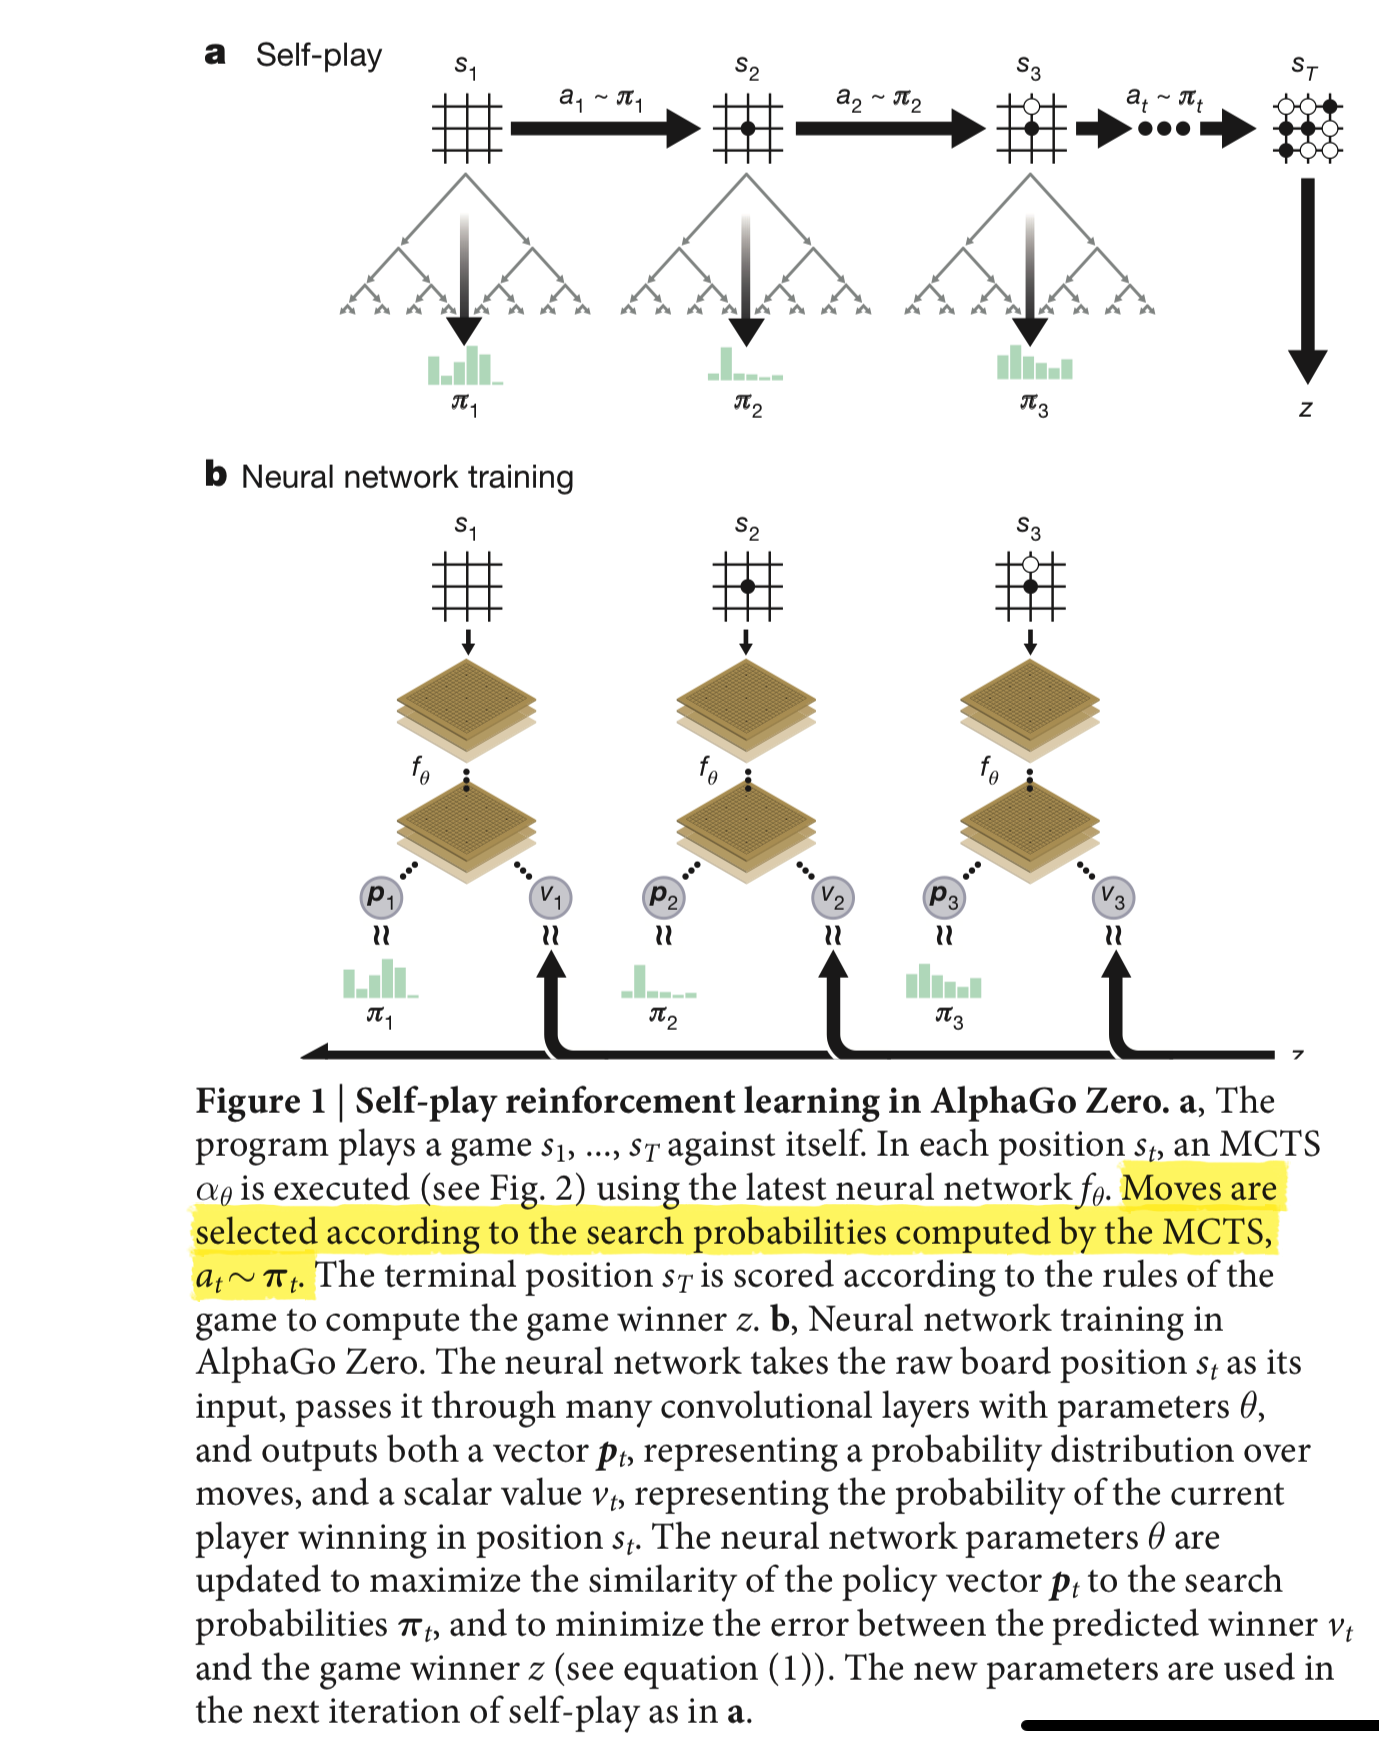